# Import

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# CA-HepTh Dataset — Summary

**What it is**
- A **collaboration network** of authors in the *High Energy Physics – Theory* (hep-th) category on **arXiv**.
- Covers submissions from **January 1993 to April 2003**.
- Each **node = an author**, each **edge = at least one co-authored paper** (undirected).
- Network scale: **9,877 nodes** and **51,971 edges**.
- Captures how scientific communities structure themselves through joint publications.

**Why it matters**
- Used to study **network properties** such as degree distribution, clustering, small-world effects, and community formation.
- Frequently referenced in network science (e.g., Newman, *PNAS*, 2001) as a benchmark for **real-world collaboration graphs**.

## Why I chose it
- It connects data analysis with **theoretical physics**, a field I genuinely enjoy.
- The dataset reflects **real scientific relationships**, not synthetic or abstract graphs.
- Perfect to explore how physicists collaborate and how knowledge spreads within a research community.

**Source:** Stanford SNAP — https://snap.stanford.edu/data/ca-HepTh.html


In [25]:
path = "CA-HepTh.txt"

G = nx.read_edgelist(
    path,
    comments="#",
    delimiter="\t",
    nodetype=int,
    create_using=nx.Graph()
)

# Check id the properties of the graph G
print(G.number_of_nodes(), "nodes")
print(G.number_of_edges(), "edges")


9877 nodes
25998 edges


# Vizualization

### Utils

In [35]:
def show_graph_from_center(H, central_node, ax, title=None):
    pos = nx.spring_layout(H, seed=42)

    # dessiner sur l'axe donné
    nx.draw_networkx_nodes(H, pos, node_size=30, ax=ax)
    nx.draw_networkx_edges(H, pos, alpha=0.25, ax=ax)
    nx.draw_networkx_nodes(H, pos, nodelist=[central_node], node_size=150, node_color="red", ax=ax)

    ax.set_axis_off()
    if title is not None:
        ax.set_title(title)

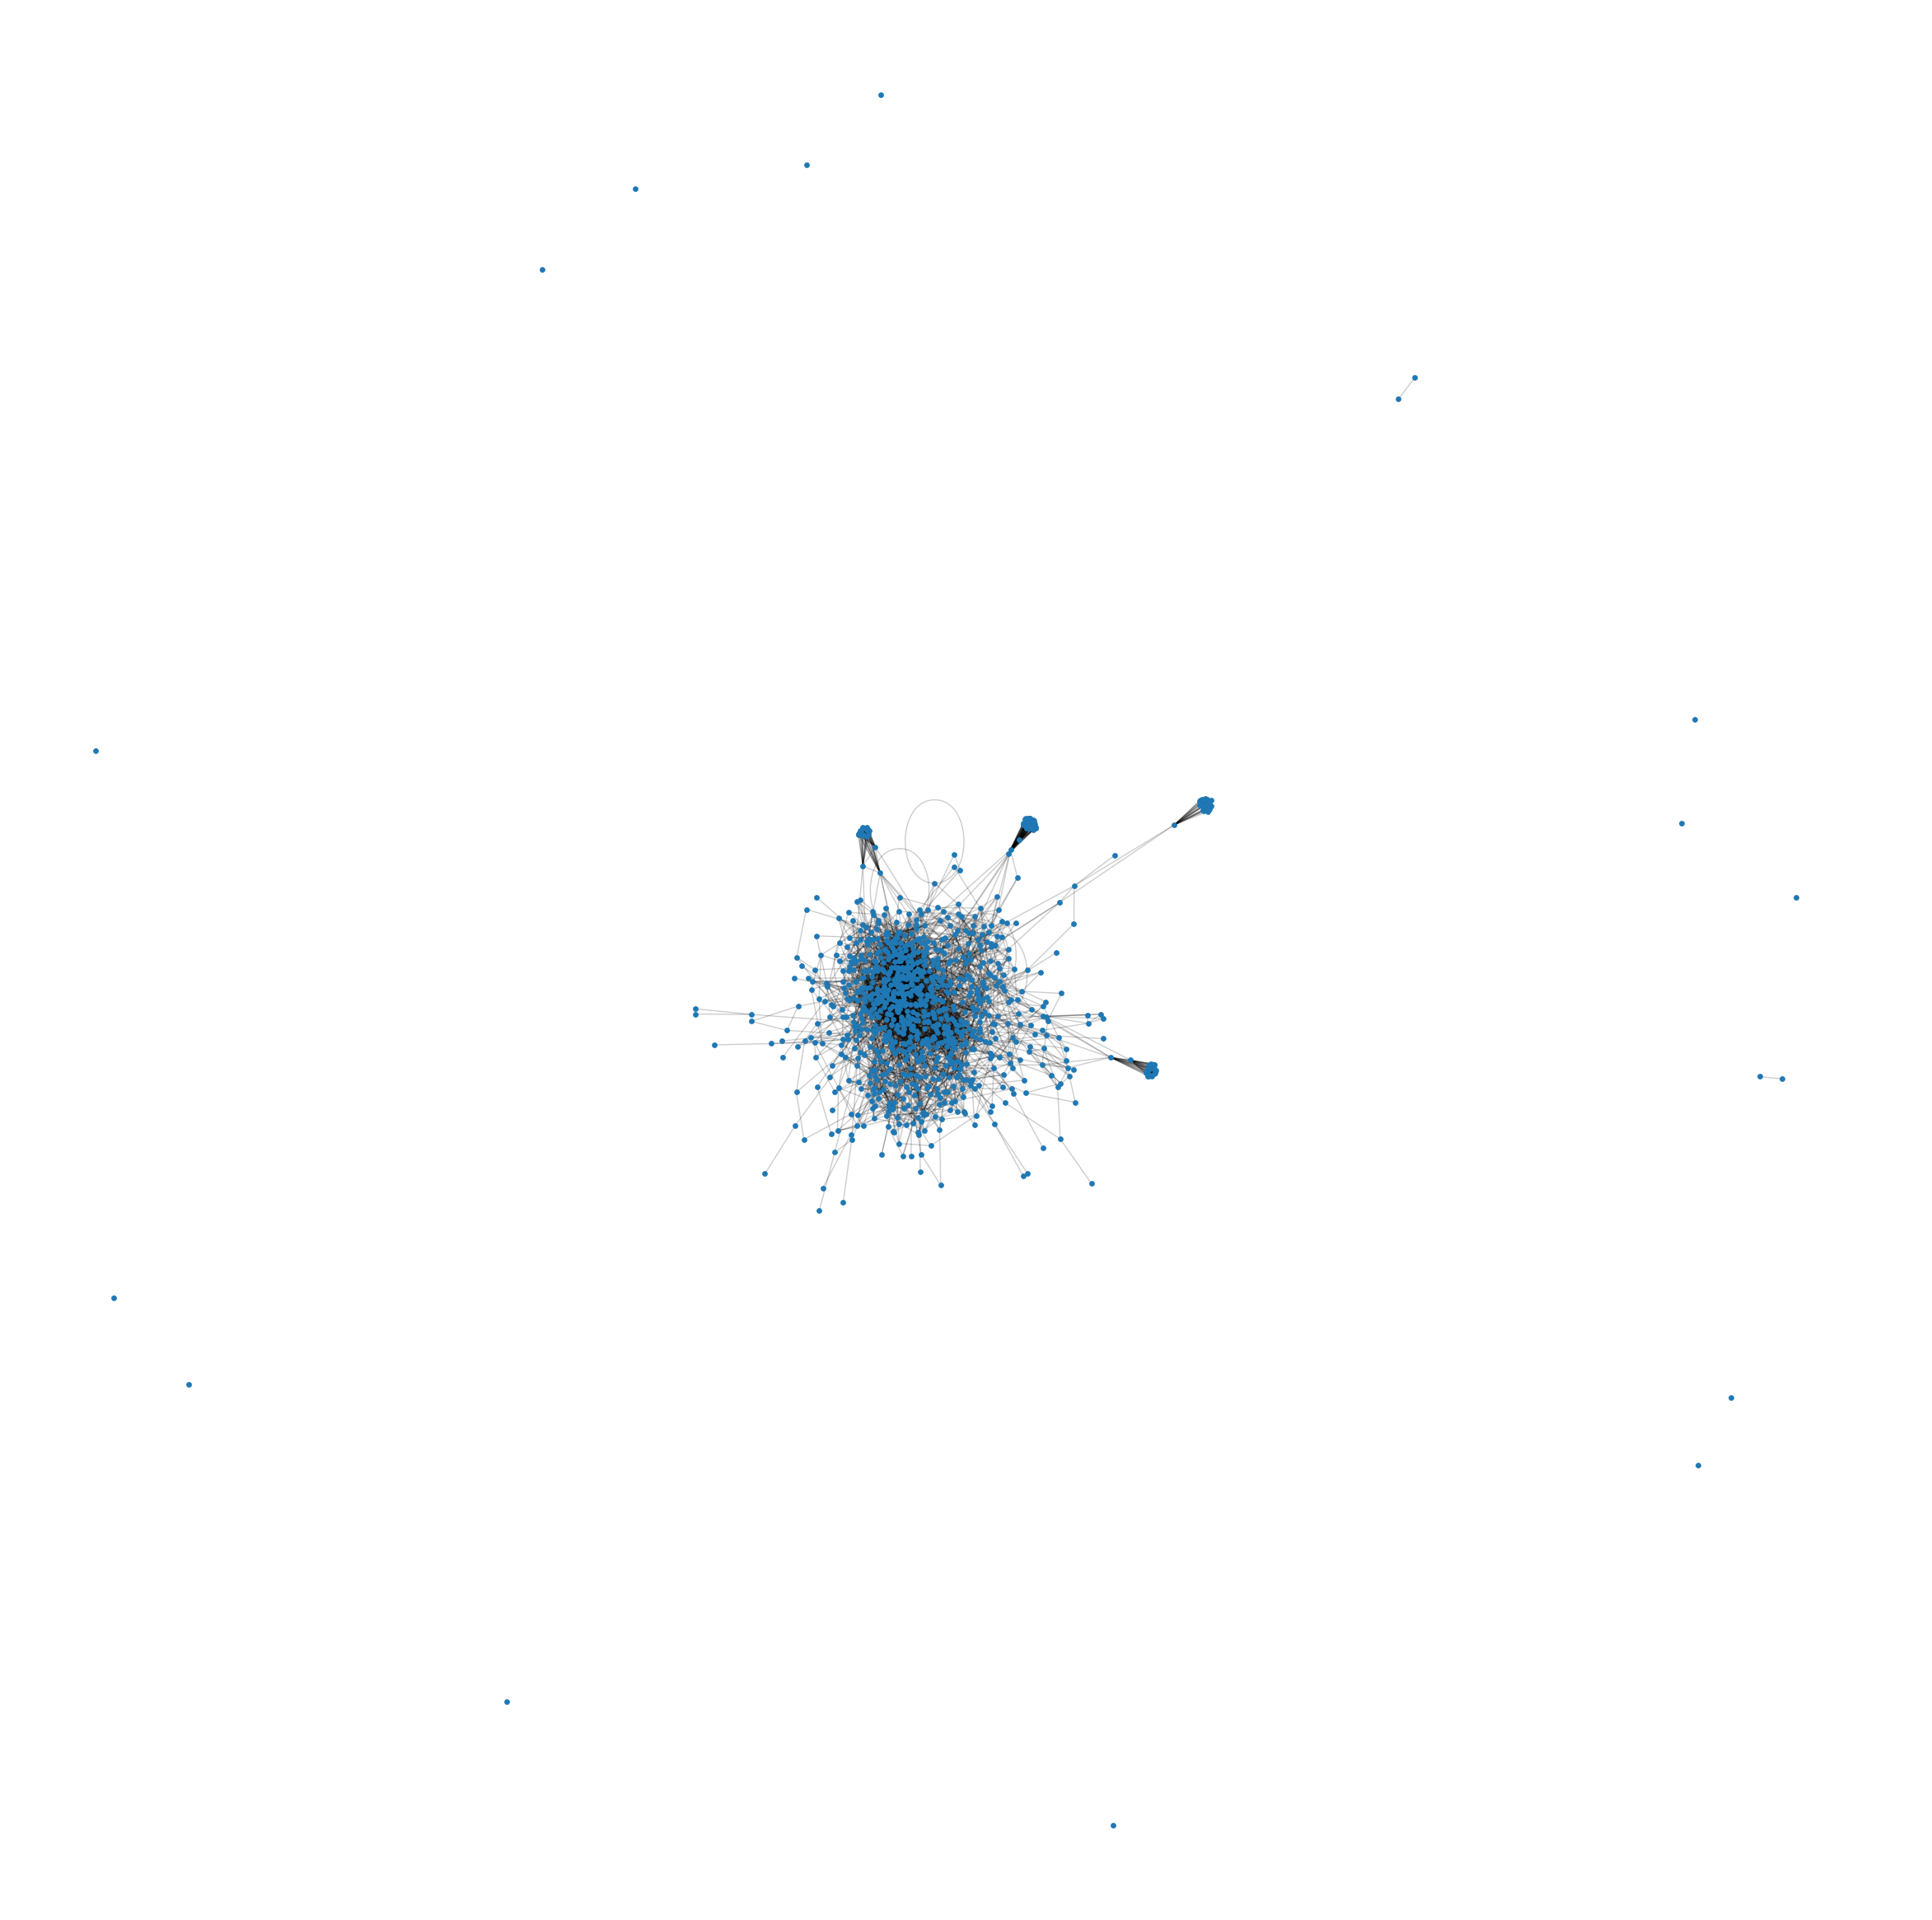

In [38]:
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:1000]
sub_nodes = [n for n, _ in top_nodes]
H = G.subgraph(sub_nodes)


plt.figure(figsize=(30,30))
pos = nx.spring_layout(H, seed=42)

nx.draw_networkx_nodes(H, pos, node_size=15)
nx.draw_networkx_edges(H, pos, alpha=0.2)

plt.axis("off")
plt.show()


Central node: 1441


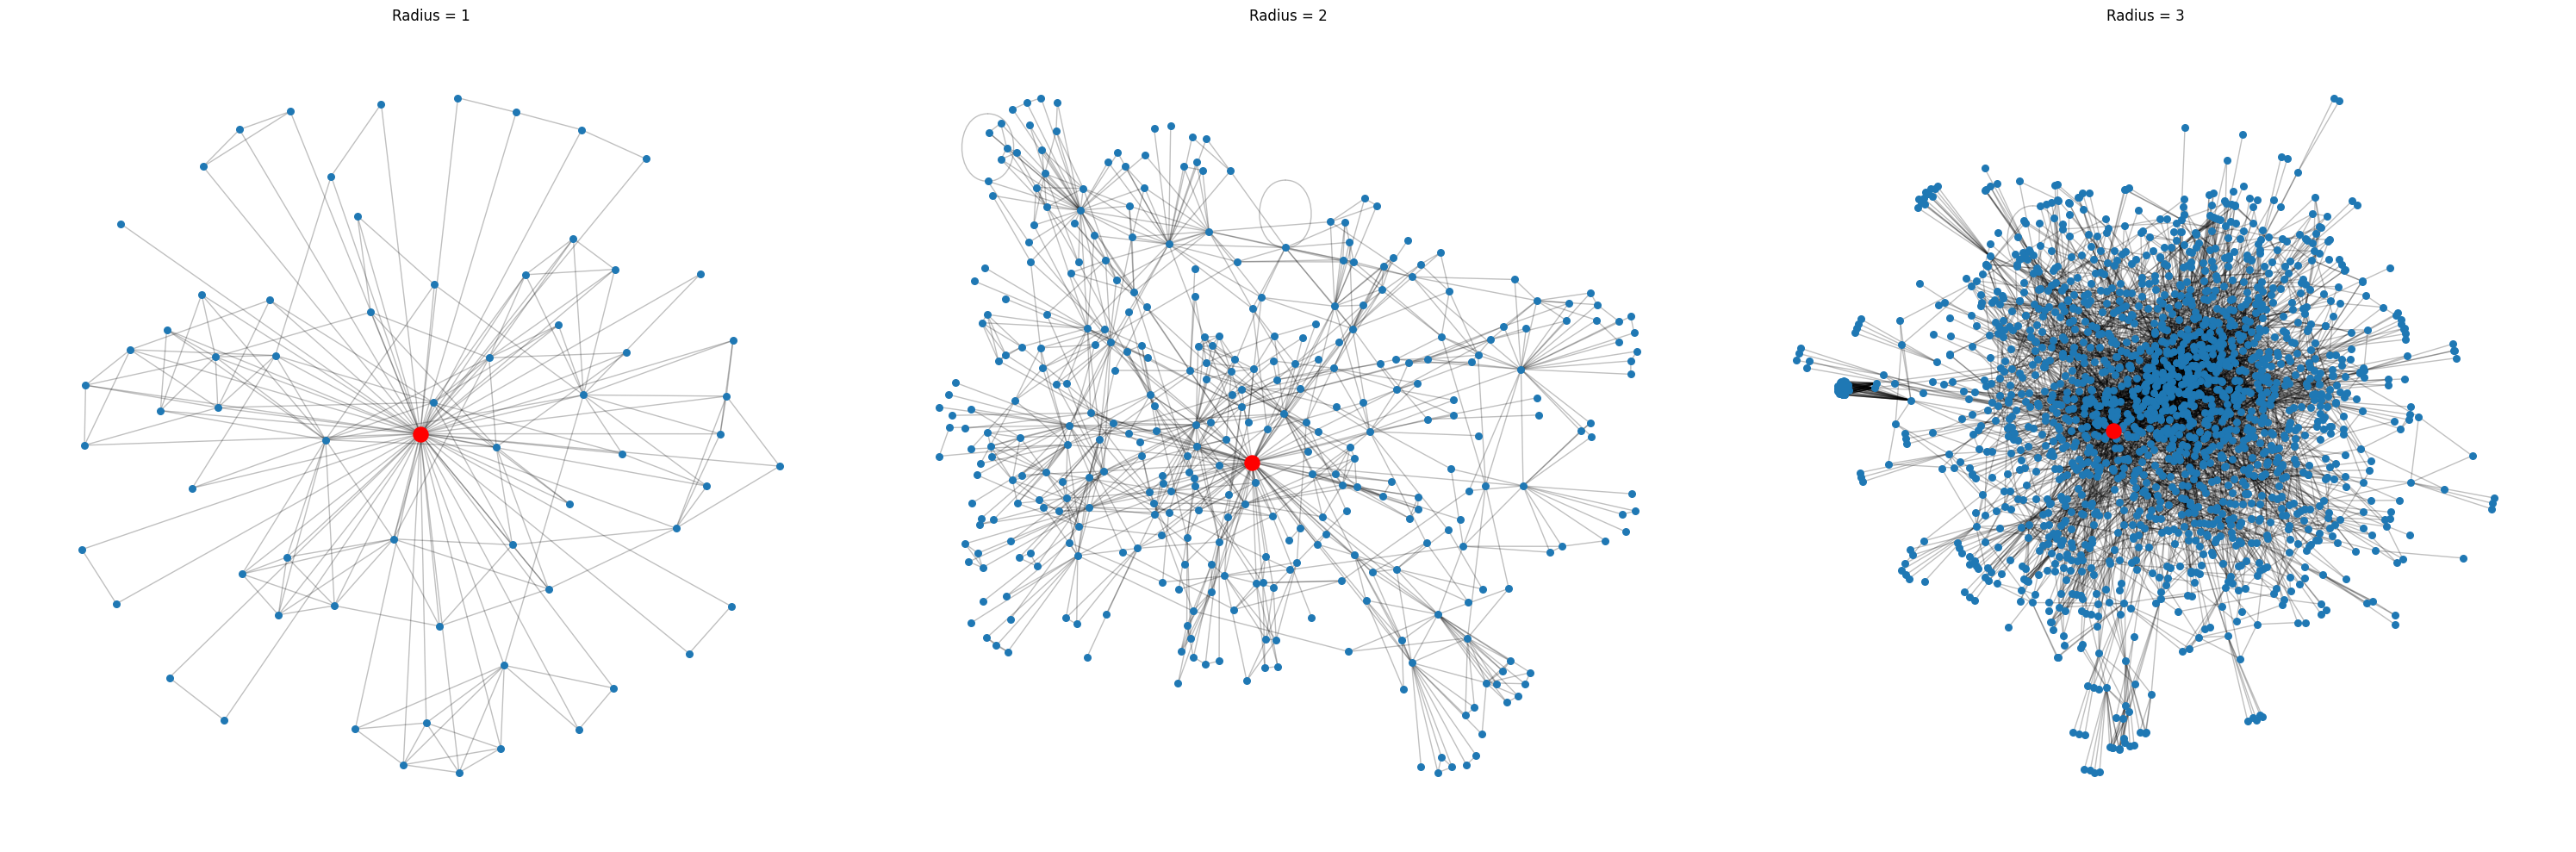

In [37]:
central_node = max(G.degree, key=lambda x: x[1])[0]
print("Central node:", central_node)

# une seule figure avec 3 colonnes
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for ax, radius in zip(axes, [1, 2, 3]):
    H = nx.ego_graph(G, central_node, radius=radius)
    show_graph_from_center(H, central_node, ax, title=f"Radius = {radius}")

plt.tight_layout()
plt.show()


## Centrality Analysis

In a collaboration network like **CA-HepTh**, centrality measures help identify
not just *who collaborates the most*, but also *who connects scientific sub-communities*.

We will use two metrics describe **different roles**:
- Degree → *popularity / collaboration volume*
- Betweenness → *strategic position / connectivity across communities*

### Degree Centrality — *local visibility*
- Measures how many **distinct co-authors** an author has.
- High-degree nodes correspond to **highly active or prolific researchers**.
- Captures **local influence** within the collaboration network.

In [43]:
deg_centrality = nx.degree_centrality(G)

# top 10 authors with highest degree centrality
top_degree = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_degree

[(1441, 0.006581611988659377),
 (19615, 0.006075334143377886),
 (63113, 0.0059740785743215875),
 (30744, 0.005670311867152693),
 (16164, 0.0054678007290400975),
 (59077, 0.005366545159983799),
 (23420, 0.005366545159983799),
 (48973, 0.005164034021871203),
 (44262, 0.005164034021871203),
 (13648, 0.005062778452814905)]

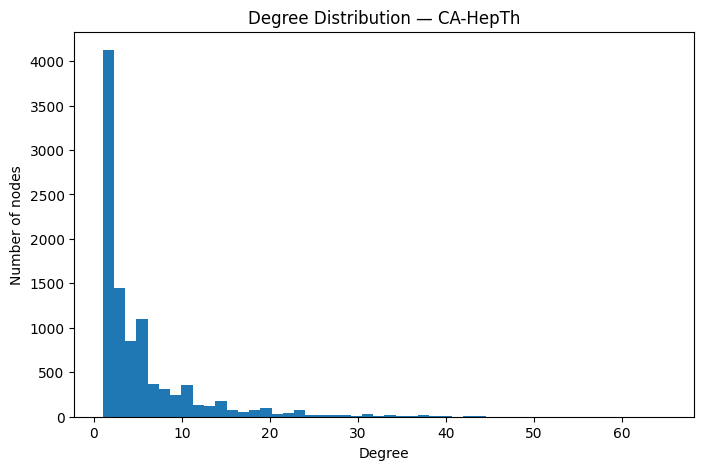

In [44]:
degrees = [d for _, d in G.degree()]

plt.figure(figsize=(8,5))
plt.hist(degrees, bins=50)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution — CA-HepTh")
plt.show()

### Betweenness Centrality — *structural brokerage*
- Measures how often a node lies on **shortest paths** between others.
- High-betweenness nodes act as **bridges between research groups**.
- Identifies **knowledge brokers** connecting subfields of theoretical physics.

In [45]:
bc = nx.betweenness_centrality(G, k=500, seed=42)

# top 10 authors with highest betweenness
top_betweenness = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness


[(44262, 0.02446894898693317),
 (19615, 0.021759279142174313),
 (30744, 0.02163464124977871),
 (43226, 0.01824221940720516),
 (14017, 0.015473962615790086),
 (62227, 0.014537534398902336),
 (37780, 0.0139804949678327),
 (24394, 0.013525827506633864),
 (1441, 0.0127018205618928),
 (33715, 0.012462022313576198)]

## Degree vs Betweenness — Comparison

This scatter shows how **activity (degree)** relates to **structural position (betweenness)**.
- Nodes high in both = **central hubs linking major groups**
- High degree but low betweenness = **local stars** inside dense communities
- Low degree but high betweenness = **rare bridges** connecting otherwise distant areas


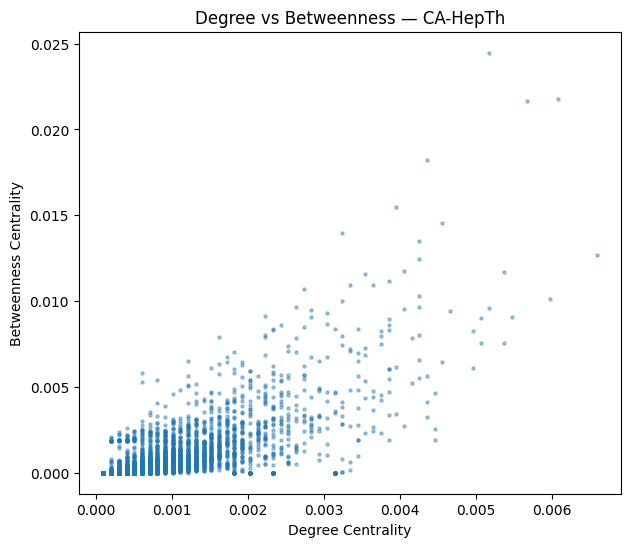

In [46]:
plt.figure(figsize=(7,6))
plt.scatter(
    [deg_centrality[n] for n in G.nodes()],
    [bc[n] for n in G.nodes()],
    s=5, alpha=0.4
)

plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Degree vs Betweenness — CA-HepTh")
plt.show()